In [1]:
%pip install numpy pandas matplotlib scikit-learn torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [2]:
LABEL_MAPPING = {
    0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"
}

In [3]:
from time import time as timer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, TensorDataset, DataLoader

In [4]:
# Loading the dataset in a numpy array format for now
df = pd.read_csv("data/data.csv")

labels = df.label.values
images = df.drop("label", axis=1).values.reshape(-1, 28, 28) / 255.0     # Also normalizing the images on hand

images.shape, labels[:10]

((60000, 28, 28), array([2, 9, 6, 0, 3, 4, 4, 5, 4, 8], dtype=int64))

In [5]:
# Getting the device on which we want our model to run
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
device

device(type='cpu')

In [6]:
# Flatten the images, and then convert them to PyTorch Tensors.
images = images.reshape(-1, 28*28)

X = torch.tensor(images, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.long)

X.shape, y.shape

(torch.Size([60000, 784]), torch.Size([60000]))

In [7]:
# Creating the dataset
dataset = TensorDataset(X, y)

In [8]:
# Splitting the dataset between training and validation sets, with a 80-20 split. Training set will 80& of data, Validation set 20%
train_ds, val_ds = random_split(dataset, [int(0.8*len(dataset)), int(0.2*len(dataset))])

# Creating the DataLoaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=True)

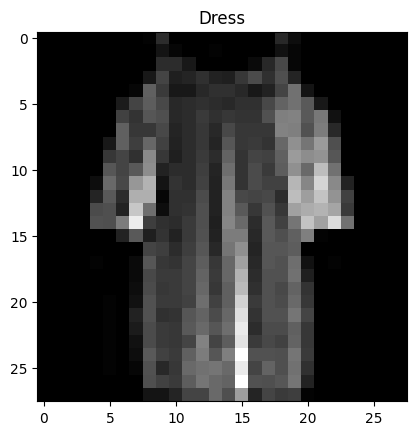

In [9]:
# Visualizing the first image of the first batch of both the loaders
for img, lbl in train_loader:
    plt.imshow(img[0].numpy().reshape((28, 28)), cmap='gray')
    plt.title(LABEL_MAPPING[lbl[0].item()])
    plt.plot()
    break

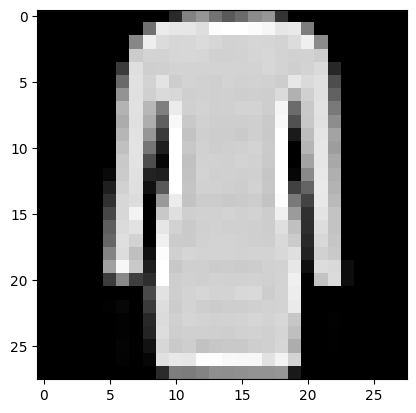

In [10]:
for img, lbl in val_loader:
    plt.imshow(img[0].numpy().reshape((28, 28)), cmap='gray')
    plt.plot()
    break

In [11]:
# Creating the model architecture
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            # Since we'll be using a Cross-Entropy Loss that already operates on probabilities of each class prediction,
            # We don't need a final activation layer in this model.
        )
    
    def forward(self, x):
        x = self.layers(x)
        return x

In [12]:
# Initializing the model
model = NN()
model

NN(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [13]:
# Printing the dimensions of all parameters
for param in model.parameters():
    print(param.shape)

torch.Size([256, 784])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [14]:
# Setting the Loss function, and the Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [15]:
# Creating the training function
def train(model, train_loader, val_loader, loss_fn, optimizer, device, n_epochs=5):
    model.to(device)
    
    for epoch in range(1, n_epochs+1):
        start_time = timer()
        
        # First training the model on the training set
        model.train()       # Set the model to training mode
        train_loss = 0.0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)              # Forward pass
            loss = loss_fn(outputs, lbls)      # Calculating the loss
            loss.backward()                    # Backpropagation
            
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)         # Divide training loss by the number of batches in the loader
        
        print(f"Epoch [{epoch}/{n_epochs}] : Training Loss: {train_loss:.4f} | ", end='')
        
        # Now checking accuracy on the validation set
        model.eval()        # Set the model to evaluation mode
        val_loss = 0.0
        correct = 0; total = 0
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
            
                outputs = model(imgs)
                loss = loss_fn(outputs, lbls)
                
                preds = torch.argmax(outputs.data, dim=1)
                
                val_loss += loss.item()
                correct += (preds == lbls).sum().item()
                total += lbls.size(0)
        
        print(f"Validation Loss: {val_loss/len(val_loader):.4f} | Accuracy: {correct/total * 100:.2f}% | Time: {timer()-start_time:.2f}")

In [16]:
# Training the model
train(model, train_loader, val_loader, loss, optimizer, device, 10)

Epoch [1/10] : Training Loss: 0.5886 | Validation Loss: 0.4303 | Accuracy: 84.76% | Time: 9.43
Epoch [2/10] : Training Loss: 0.4032 | Validation Loss: 0.3991 | Accuracy: 85.82% | Time: 12.64
Epoch [3/10] : Training Loss: 0.3571 | Validation Loss: 0.3841 | Accuracy: 86.02% | Time: 11.20
Epoch [4/10] : Training Loss: 0.3279 | Validation Loss: 0.3439 | Accuracy: 87.88% | Time: 11.13
Epoch [5/10] : Training Loss: 0.3086 | Validation Loss: 0.3379 | Accuracy: 87.86% | Time: 10.17
Epoch [6/10] : Training Loss: 0.2934 | Validation Loss: 0.3251 | Accuracy: 88.41% | Time: 9.55
Epoch [7/10] : Training Loss: 0.2799 | Validation Loss: 0.3272 | Accuracy: 88.27% | Time: 10.95
Epoch [8/10] : Training Loss: 0.2659 | Validation Loss: 0.3103 | Accuracy: 88.91% | Time: 10.89
Epoch [9/10] : Training Loss: 0.2552 | Validation Loss: 0.3331 | Accuracy: 87.93% | Time: 11.32
Epoch [10/10] : Training Loss: 0.2438 | Validation Loss: 0.3345 | Accuracy: 88.38% | Time: 10.76


Awesome, with just 10 epochs on a CPU, we got an accuracy of 88% on this dataset. Let's go ahead and save this model

In [17]:
torch.save(model.state_dict(), "model.pth")

## Loading the model, and using it to make predictions

In [18]:
model = NN()
model.load_state_dict(torch.load("model.pth"))

C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_27252\897295948.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


<All keys matched successfully>

In [19]:
def make_prediction(model, sample):
    if isinstance(sample, np.ndarray):
        inputs = torch.tensor(sample.reshape(-1, 28*28) / 255.0, dtype=torch.float32)
    elif isinstance(sample, str):
        img = Image.open(sample).convert("L").resize((28, 28))
        img_arr = np.array(img)
        
        inputs = torch.tensor(img_arr.reshape(-1, 28*28) / 255.0, dtype=torch.float32)
    elif isinstance(sample, torch.Tensor):
        inputs = sample
    else: raise ValueError("Error: sample must be a numpy.ndarray, a PathLike-string, or a torch.Tensor object")
    
    # Ensure inputs have a batch dimension
    if inputs.dim() == 1:
        inputs = inputs.unsqueeze(0)  # Add batch dimension
    
    model.eval()
    with torch.no_grad():
        output = model(inputs)
        pred = torch.argmax(output.data, dim=1).item()
    
    img = inputs.reshape((28, 28)).numpy()
    
    return img, pred

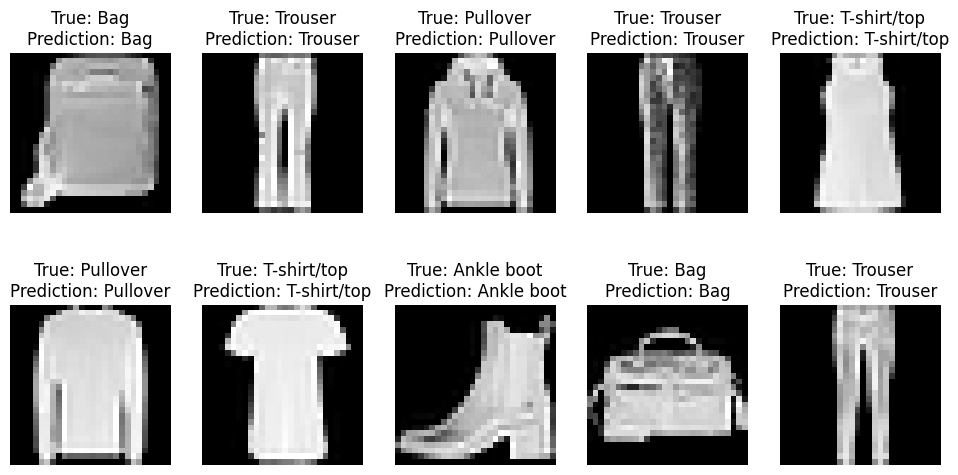

In [20]:
# Visualizing the function for the first 10 images of the first batch of the val_loader
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
ax = ax.ravel()

for imgs, lbls in val_loader:
    for i in range(10):
        img, pred = make_prediction(model, imgs[i])
        
        ax[i].imshow(img, cmap='gray')
        ax[i].set_title(f"True: {LABEL_MAPPING[lbls[i].item()]}\nPrediction: {LABEL_MAPPING[pred]}")
        ax[i].axis("off")
    break